In [ ]:
library(tidyverse)
library(repr)
library(tidymodels)
source("tests.R")
source('cleanup.R')
set.seed(1000)

Pollutant levels or concentrations in the atmosphere lead to changes in the climate such as an increase in temperature and humidity levels. Measuring atmospheric pollutant concentrations requires air quality monitors and satellite imagery. Using other predictors such as temperature and humidity levels to determine concentration could be effective and less costly. This project aims to assess whether a linear regression model can be used to predict the average daily chemical concentration of tungsten oxide given averages of relative humidity, absolute humidity and temperature.

The data used was collected in an Italian city every hour in 2004, resulting in 9358 total observations in the dataset. The variables are: date, time, temperature (T), absolute humidity (AH), relative humidity (RH), and concentrations for carbon monoxide (CO), tin oxide (PT08.S1), non-methane hydrocarbons (NMHC), benzene (C6H6), titania (PT08.S1), nitric oxides (NOx, where x= 1,2,3, or 4), tungsten oxide (PT08.S3(NOx), and PT08.S4(NO2)), nitrogen dioxide(NO2), and indium oxide (PT08.S5).

In [2]:
air_quality <- read_csv("https://raw.githubusercontent.com/recompton/DSCI100_group_project/main/AirQualityUCI.csv?token=GHSAT0AAAAAACPKFCCOAGKVC5S4EIWAUNNAZPMZKGA")
head(air_quality)

library(GGally)

New names:
• `` -> `...16`
• `` -> `...17`
Rows: 9471 Columns: 17
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr   (1): Date
dbl  (13): CO_GT, PT08.S1_CO, NMHC_GT, C6H6_GT, PT08.S2_NMHC, Nox_GT, PT08.S...
lgl   (2): ...16, ...17
time  (1): Time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Date      Time     CO_GT PT08.S1_CO NMHC_GT C6H6_GT PT08.S2_NMHC Nox_GT
1 3/10/2004 18:00:00 2.6   1360       150     11.9    1046         166   
2 3/10/2004 19:00:00 2.0   1292       112      9.4     955         103   
3 3/10/2004 20:00:00 2.2   1402        88      9.0     939         131   
4 3/10/2004 21:00:00 2.2   1376        80      9.2     948         172   
5 3/10/2004 22:00:00 1.6   1272        51      6.5     836         131   
6 3/10/2004 23:00:00 1.2   1197        38      4.7     750          89   
  PT08.S3_Nox NO2_GT PT08.S4_NO2 PT08.S5_O3 T    RH   AH     ...16 ...17
1 1056        113    1692        1268       13.6 48.9 0.7578 NA    NA   
2 1174         92    1559         972       13.3 47.7 0.7255 NA    NA   
3 1140        114    1555        1074       11.9 54.0 0.7502 NA    NA   
4 1092        122    1584        1203       11.0 60.0 0.7867 NA    NA   
5 1205        116    1490        1110       11.2 59.6 0.7888 NA    NA   
6 1337         96    1393         949       11.2 59.2 0.7848 NA    NA

Warning message:
“package ‘GGally’ was built under R version 4.3.2”
Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2



Before starting the analysis, we tidied our data with a single pollutant column, since we are only looking at tungsten oxide. In an ideal situation, we expect 365 observations in our wrangled data. During wrangling, we changed the pollutant column name from PT08.S4(NO2) to PT08.S4_NO2, as R was interpreting the name as a function. The format of the date was also changed from year/month/day to month-day-year, and split into 3 columns to compute the daily average. The data also had extraneous rows and columns which were removed. There were 130 rows with no values, and two columns labeled 16 and 17 which only had NA listed in every row.

In [4]:
air_quality_1 <- mutate(air_quality, Date = mdy(Date))
head(air_quality_1)

Date       Time     CO_GT PT08.S1_CO NMHC_GT C6H6_GT PT08.S2_NMHC Nox_GT
1 2004-03-10 18:00:00 2.6   1360       150     11.9    1046         166   
2 2004-03-10 19:00:00 2.0   1292       112      9.4     955         103   
3 2004-03-10 20:00:00 2.2   1402        88      9.0     939         131   
4 2004-03-10 21:00:00 2.2   1376        80      9.2     948         172   
5 2004-03-10 22:00:00 1.6   1272        51      6.5     836         131   
6 2004-03-10 23:00:00 1.2   1197        38      4.7     750          89   
  PT08.S3_Nox NO2_GT PT08.S4_NO2 PT08.S5_O3 T    RH   AH     ...16 ...17
1 1056        113    1692        1268       13.6 48.9 0.7578 NA    NA   
2 1174         92    1559         972       13.3 47.7 0.7255 NA    NA   
3 1140        114    1555        1074       11.9 54.0 0.7502 NA    NA   
4 1092        122    1584        1203       11.0 60.0 0.7867 NA    NA   
5 1205        116    1490        1110       11.2 59.6 0.7888 NA    NA   
6 1337         96    1393         949       11.2 59.2 0.7848 NA    NA

In [7]:
air_quality_2 <- air_quality_1 |>
mutate(year = year(Date),
month = month(Date),
day = day(Date))

head(air_quality_2)

Date       Time     CO_GT PT08.S1_CO NMHC_GT C6H6_GT PT08.S2_NMHC Nox_GT
1 2004-03-10 18:00:00 2.6   1360       150     11.9    1046         166   
2 2004-03-10 19:00:00 2.0   1292       112      9.4     955         103   
3 2004-03-10 20:00:00 2.2   1402        88      9.0     939         131   
4 2004-03-10 21:00:00 2.2   1376        80      9.2     948         172   
5 2004-03-10 22:00:00 1.6   1272        51      6.5     836         131   
6 2004-03-10 23:00:00 1.2   1197        38      4.7     750          89   
  PT08.S3_Nox NO2_GT PT08.S4_NO2 PT08.S5_O3 T    RH   AH     ...16 ...17 year
1 1056        113    1692        1268       13.6 48.9 0.7578 NA    NA    2004
2 1174         92    1559         972       13.3 47.7 0.7255 NA    NA    2004
3 1140        114    1555        1074       11.9 54.0 0.7502 NA    NA    2004
4 1092        122    1584        1203       11.0 60.0 0.7867 NA    NA    2004
5 1205        116    1490        1110       11.2 59.6 0.7888 NA    NA    2004
6 1337         96    1393         949       11.2 59.2 0.7848 NA    NA    2004
  month day
1 3     10 
2 3     10 
3 3     10 
4 3     10 
5 3     10 
6 3     10

In [8]:
sliced_air_quality <- air_quality_2 |>
slice(1:9357) 


head(sliced_air_quality)

Date       Time     CO_GT PT08.S1_CO NMHC_GT C6H6_GT PT08.S2_NMHC Nox_GT
1 2004-03-10 18:00:00 2.6   1360       150     11.9    1046         166   
2 2004-03-10 19:00:00 2.0   1292       112      9.4     955         103   
3 2004-03-10 20:00:00 2.2   1402        88      9.0     939         131   
4 2004-03-10 21:00:00 2.2   1376        80      9.2     948         172   
5 2004-03-10 22:00:00 1.6   1272        51      6.5     836         131   
6 2004-03-10 23:00:00 1.2   1197        38      4.7     750          89   
  PT08.S3_Nox NO2_GT PT08.S4_NO2 PT08.S5_O3 T    RH   AH     ...16 ...17 year
1 1056        113    1692        1268       13.6 48.9 0.7578 NA    NA    2004
2 1174         92    1559         972       13.3 47.7 0.7255 NA    NA    2004
3 1140        114    1555        1074       11.9 54.0 0.7502 NA    NA    2004
4 1092        122    1584        1203       11.0 60.0 0.7867 NA    NA    2004
5 1205        116    1490        1110       11.2 59.6 0.7888 NA    NA    2004
6 1337         96    1393         949       11.2 59.2 0.7848 NA    NA    2004
  month day
1 3     10 
2 3     10 
3 3     10 
4 3     10 
5 3     10 
6 3     10

In [9]:
avg_air_quality <- sliced_air_quality |>
filter(PT08.S4_NO2	 != -200)|>
filter(T != -200) |>
filter(RH != -200) |>
filter(AH != -200) |>
group_by(month, day) |>
summarize(
    daily_avg_TO = mean(PT08.S4_NO2, na.rm = TRUE),
    daily_avg_T = mean(T, na.rm = TRUE),
    daily_avg_RH = mean(RH, na.rm = TRUE),
    daily_avg_AH = mean(AH, na.rm = TRUE))


avg_air_quality_split <- initial_split(avg_air_quality, prop = 0.75, strata = daily_avg_TO)
avg_air_quality_train <- training(avg_air_quality_split)
avg_air_quality_test <- testing(avg_air_quality_split)

avg_air_quality_train
avg_air_quality_test

`summarise()` has grouped output by 'month'. You can override using the
`.groups` argument.


month day daily_avg_TO daily_avg_T daily_avg_RH daily_avg_AH
1   1      1  1032.6250     6.870833   50.79583     0.4989708   
2   1      6  1226.5417    13.445833   61.07083     0.9321417   
3   1      9  1257.7500    14.437500   58.99583     0.9614458   
4   1     15  1210.5000     6.429167   70.20417     0.6710333   
5   1     16   948.3333     7.525000   47.77917     0.4804167   
6   1     19  1072.4583     7.816667   64.99583     0.6895000   
7   1     20  1136.7500    10.075000   44.24583     0.5263417   
8   1     22  1283.5000     9.941667   55.85417     0.6523542   
9   1     25   869.3750     4.512500   50.97083     0.4323125   
10  1     26   873.0417     4.208333   49.48333     0.4119333   
11  1     28   885.0000     3.982353   48.45882     0.3979588   
12  1     30   763.7917     4.850000   37.83750     0.3249958   
13  1     31  1001.5000     7.283333   31.80833     0.3119542   
14  2      2  1132.2083     7.612500   43.93750     0.4263500   
15  2      3  1212.2083     7.254167   50.96250     0.5132417   
16  2      4  1081.7500     7.466667   50.17917     0.4960292   
17  2      5   926.8333     5.570833   46.60417     0.4109500   
18  2      6   821.7500     5.304167   39.60000     0.3437333   
19  2      7   873.2500     7.304167   35.40000     0.3529917   
20  2      8   904.2941     8.764706   36.12353     0.3957765   
21  2     15   881.1250     8.962500   30.21250     0.3368375   
22  2     16  1052.3333     6.491667   42.62500     0.4093333   
23  2     17  1000.9167     7.491667   44.40000     0.4630750   
24  2     18  1012.5000     8.504167   42.18333     0.4623958   
25  2     19   997.8333     6.733333   47.69167     0.4547792   
26  2     20   987.0000     8.304167   54.17500     0.5936167   
27  2     21  1179.4167     5.750000   74.30000     0.6858208   
28  2     23  1113.0417     4.320833   78.37917     0.6580625   
29  2     24  1220.0417     5.270833   78.72500     0.7039125   
30  2     25  1212.0417     7.920833   62.69583     0.6468708   
⋮   ⋮     ⋮   ⋮            ⋮           ⋮            ⋮           
236  8     3  1768.333     30.70417    41.35000     1.7445750   
237  8     4  1698.083     30.57500    42.05833     1.7195250   
238  8     6  1803.917     26.48333    58.03750     1.8899667   
239  8    10  1706.208     31.54583    43.88750     1.8547083   
240  8    11  1700.417     31.50000    46.00417     1.9978125   
241  8    31  1684.958     27.30000    46.18333     1.5827333   
242  9     2  1675.125     28.91667    38.06667     1.3910167   
243  9     3  1689.958     29.97917    37.23750     1.4423208   
244  9    13  1775.917     26.25833    50.00000     1.5848250   
245  9    14  1716.250     25.19583    55.95417     1.7135500   
246  9    21  1726.042     24.70417    47.61667     1.4230500   
247  9    22  1728.083     24.60417    51.27917     1.4947625   
248 10     1  1769.957     22.07391    60.23478     1.5639739   
249 10     4  1729.292     22.17500    56.58333     1.4520333   
250 10     6  1736.417     22.77917    55.64583     1.4917375   
251 10     7  1744.333     23.12917    54.57083     1.4954625   
252 10     8  1725.708     23.28750    54.93333     1.5154083   
253 10     9  1724.000     24.88333    54.79167     1.6757875   
254 10    11  1673.292     19.93333    67.12083     1.5403167   
255 10    19  1744.250     18.21667    67.02083     1.3843500   
256 10    20  1959.375     21.72083    66.21667     1.6928042   
257 10    21  1830.792     23.82083    60.47083     1.7434750   
258 10    22  1799.708     22.52917    61.64583     1.6456625   
259 10    25  1827.000     18.65833    69.75000     1.4794417   
260 10    26  1804.917     19.52917    66.21250     1.4673333   
261 11     1  1706.167     21.22917    70.09167     1.7422583   
262 11     2  1893.542     20.66667    64.50000     1.5346500   
263 11     4  1747.583     20.57917    62.00417     1.4643958   
264 11     5  1682.042     19.34583    62.23333     1.3682583   
265 11    23  1731.167     10.73333    

month day daily_avg_TO daily_avg_T daily_avg_RH daily_avg_AH
1  1      2  1063.1429     6.580952   59.28095     0.5709476   
2  1     10  1482.9167    13.320833   68.66250     1.0445833   
3  1     17  1163.3333     6.666667   46.91667     0.4469125   
4  1     18  1306.3750     5.287500   66.27500     0.6079667   
5  1     23   998.7500     5.816667   53.88333     0.5014125   
6  1     24   977.4583     7.675000   47.88333     0.4938125   
7  1     27   870.9583     5.270833   39.61250     0.3543292   
8  1     29   807.0455     2.618182   49.34545     0.3679773   
9  2      1  1184.4167     6.625000   51.74167     0.5041875   
10 2     11  1315.6667     7.966667   54.10000     0.5797333   
11 2     14  1020.7917    10.479167   40.69583     0.5037500   
12 2     22  1182.7917     5.412500   75.16250     0.6742750   
13 2     28   750.0833     2.887500   42.66667     0.3272292   
14 3      5  1053.9167     8.233333   51.93333     0.5436167   
15 3      8  1048.6250     7.525000   39.19167     0.3688333   
16 3     10  1242.6333    11.420000   48.15333     0.5881967   
17 3     13  1372.5833    13.625000   50.72917     0.7697083   
18 3     17  1511.7708    18.020833   41.38542     0.7722146   
19 3     18  1510.8125    16.722917   45.03958     0.7858896   
20 3     21  1513.8333    16.914583   53.99167     1.0059833   
21 3     24  1496.8333    14.420833   54.32708     0.8741292   
22 3     28  1314.4167    15.695833   53.24583     0.9249792   
23 3     30  1387.8333    16.470833   44.25000     0.7955292   
24 3     31  1345.0417    15.568750   52.55417     0.8968542   
25 4      4  1421.1026    18.148718   47.32564     0.9196795   
26 4      9  1560.0000    12.000000   67.90000     0.9523000   
27 4     11  1265.6667    14.775000   43.76250     0.6673417   
28 4     14  1582.0833    15.487500   47.35833     0.7877292   
29 4     18  1559.0417    15.595833   64.13750     1.1218500   
30 4     24  1667.5417    20.083333   48.52083     1.0794292   
⋮  ⋮     ⋮   ⋮            ⋮           ⋮            ⋮           
63  8    26  1321.667     23.700000   45.30000     1.3099167   
64  9     1  1683.542     27.070833   42.09167     1.3834833   
65  9     4  1511.792     30.370833   34.64583     1.3665917   
66  9     8  1453.571     27.214286   27.37143     0.9562571   
67  9     9  1460.333     28.525000   26.55000     0.9646708   
68  9    10  1447.125     27.912500   30.61250     1.0772750   
69  9    11  1427.458     27.208333   35.55000     1.2052792   
70  9    15  1846.667     22.841667   67.76667     1.8466792   
71  9    16  1656.917     21.429167   61.10833     1.5256000   
72  9    17  1440.000     21.800000   48.52917     1.2407292   
73  9    23  1703.417     25.495833   50.78750     1.5961458   
74  9    28  1511.833     19.891667   42.39167     0.9168000   
75 10     5  1763.333     23.158333   53.55000     1.4494958   
76 10    16  1352.542     17.408333   62.10417     1.1790667   
77 10    18  1634.750     17.345833   60.38750     1.1775333   
78 10    29  1613.583     19.454167   73.89167     1.6502750   
79 11     7  1113.958     15.883333   45.86667     0.8194917   
80 11    10  1210.917      8.745833   71.81667     0.8065708   
81 11    17  1321.042     10.941667   51.70000     0.6634042   
82 11    19  1422.167     15.858333   53.78750     0.9747250   
83 11    25  1322.042     10.020833   63.45833     0.7452958   
84 11    28  1237.458     10.650000   72.65833     0.9287042   
85 11    30  1395.708     12.987500   71.59583     1.0658500   
86 12     8  1258.792     14.354167   64.54583     1.0434833   
87 12    11  1024.458     13.441667   31.16250     0.4588417   
88 12    12  1185.250      9.979167   51.63333     0.6170625   
89 12    13  1358.667     10.108333   56.78750     0.6927458   
90 12    14  1391.529      9.852941   65.49412     0.7834529   
91 12    26  1216.500     12.045833   74.80000     1.0445417   
92 12    27  1214.917     12.554167   65.45417     0.9473042

In [10]:
num_rows <- nrow(avg_air_quality_train)
num_rows

[1] 265

We chose PT08.S4(NO2) because it has 357 rows total (265 in the training data) after filtering out the NA (-200) values. Additionally, this chemical showed promise for a good correlation when visualizing its relationship with RH, AH and T in our preliminary exploratory analysis. To make our analysis reproducible, we set the seed to 1000.

To visualize the outcome of the regression model, we will have 3 scatterplots with AH, RH and temperature on the x-axis and concentration of tungsten oxide on the y-axis. We will also include a regression line in each plot.

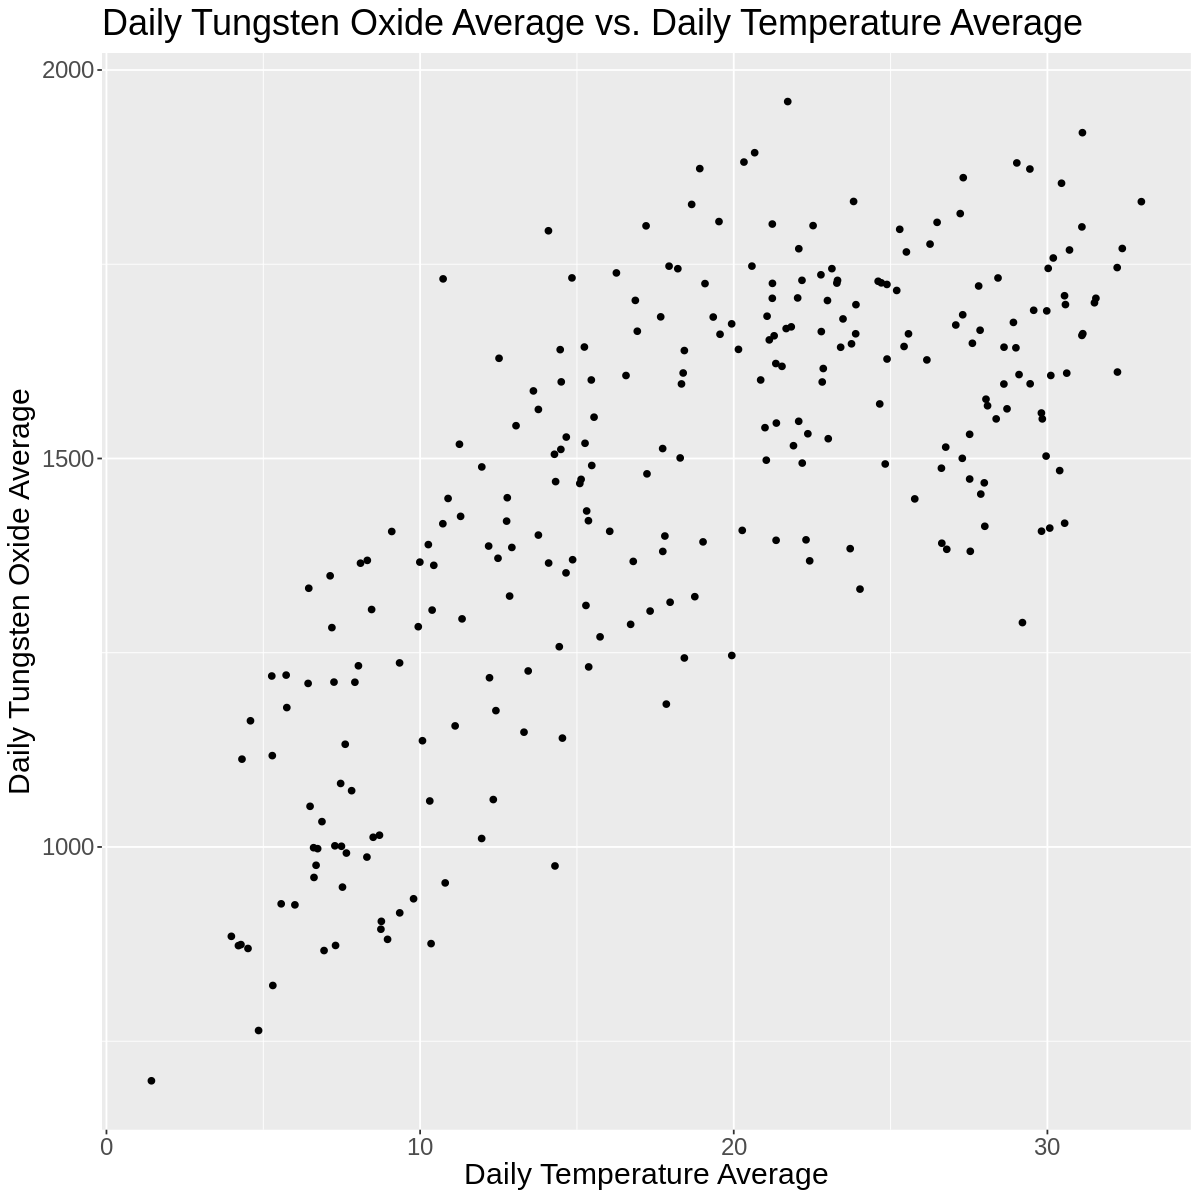

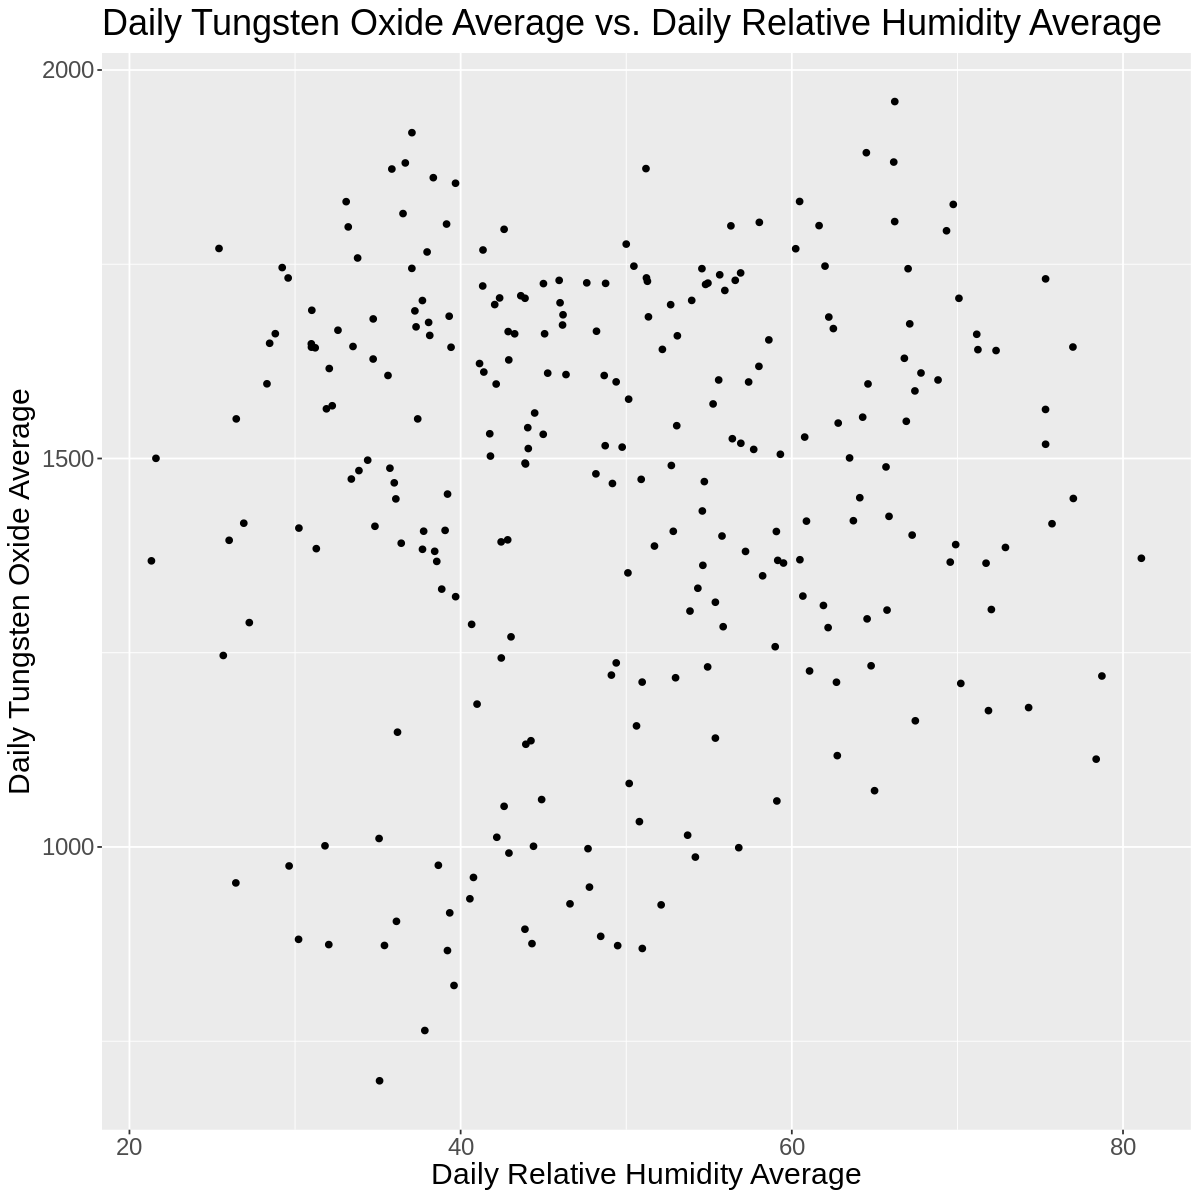

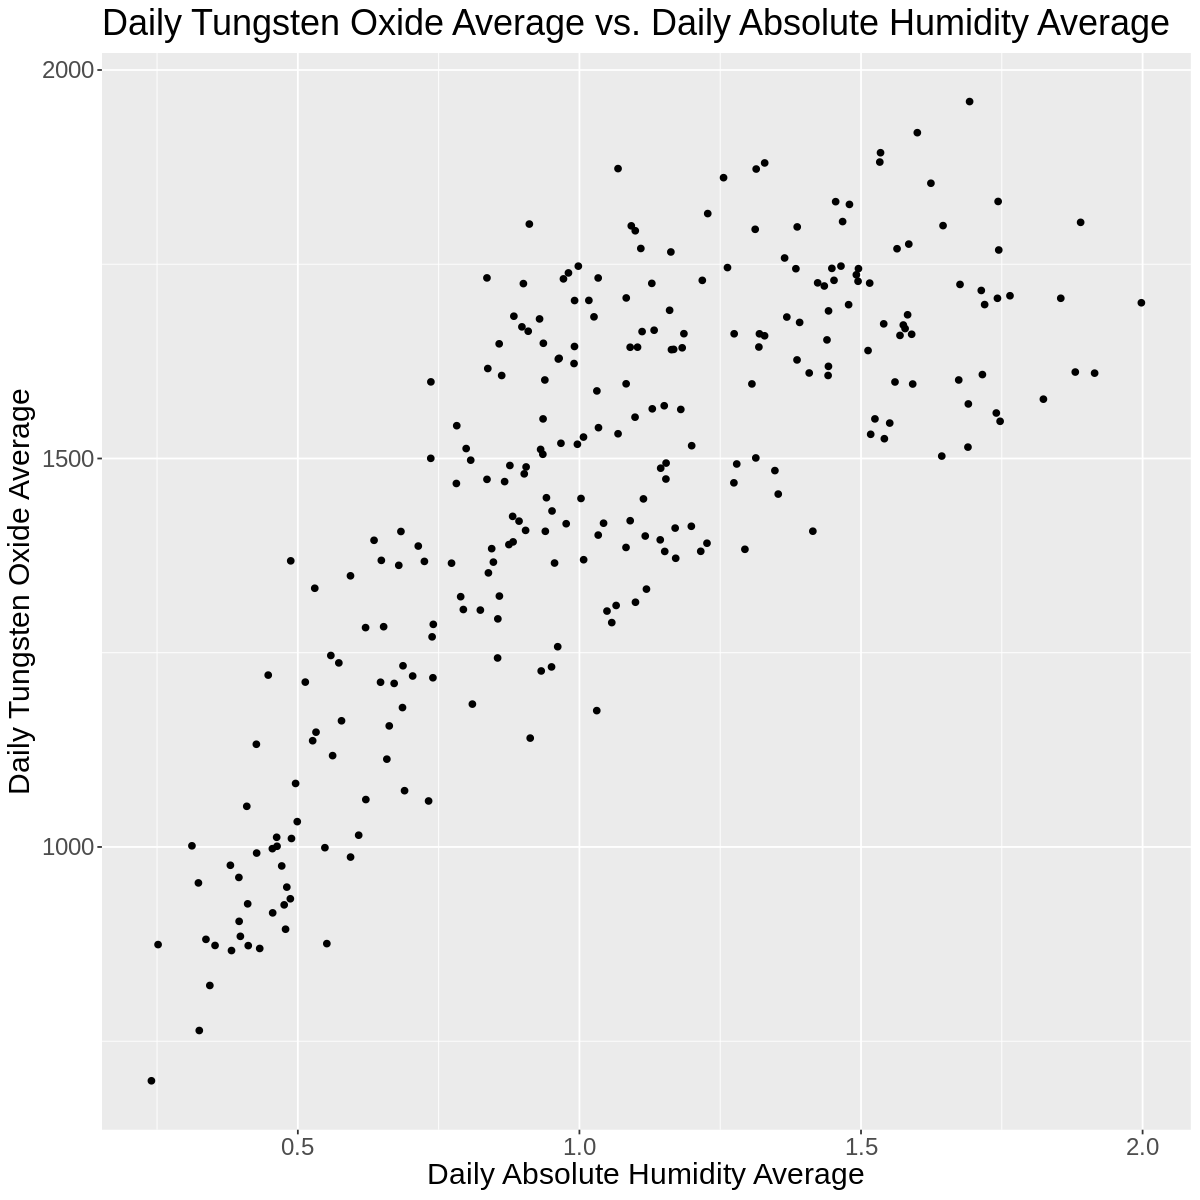

In [11]:
options(repr.plot.width = 10, repr.plot.height = 10)

ggplot(avg_air_quality_train, aes(x = daily_avg_T, y = daily_avg_TO)) +
  geom_point() +
  labs(title = "Daily Tungsten Oxide Average vs. Daily Temperature Average",
       x = "Daily Temperature Average",
       y = "Daily Tungsten Oxide Average") +
theme(text = element_text(size = 18))

ggplot(avg_air_quality_train, aes(x = daily_avg_RH, y = daily_avg_TO)) +
  geom_point() +
  labs(title = "Daily Tungsten Oxide Average vs. Daily Relative Humidity Average",
       x = "Daily Relative Humidity Average",
       y = "Daily Tungsten Oxide Average") +
theme(text = element_text(size = 18))

ggplot(avg_air_quality_train, aes(x = daily_avg_AH, y = daily_avg_TO)) +
  geom_point() +
  labs(title = "Daily Tungsten Oxide Average vs. Daily Absolute Humidity Average",
       x = "Daily Absolute Humidity Average",
       y = "Daily Tungsten Oxide Average") + 
theme(text = element_text(size = 18))

Following our data analysis and visualization, we expect to find that as temperature and humidity levels increase, more levels of tungsten oxide will be present in the atmosphere. We also expect chemical accumulation in the atmosphere over time, resulting in a regression line with a positive slope.These findings can be useful in determining how pollutant levels change overtime and if temperature and humidity levels can be good predictors. If they are not good predictors, then there will not be a clear relationship. These findings could also lead to questions such as: If we expanded the study by year from 2004 to 2022, would a relationship be more prominent? What are the large scale effects of pollutant accumulation? Are there any other factors besides pollutant accumulation which lead to increase AH, RH or temperature?

Adding missing grouping variables: `month`
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


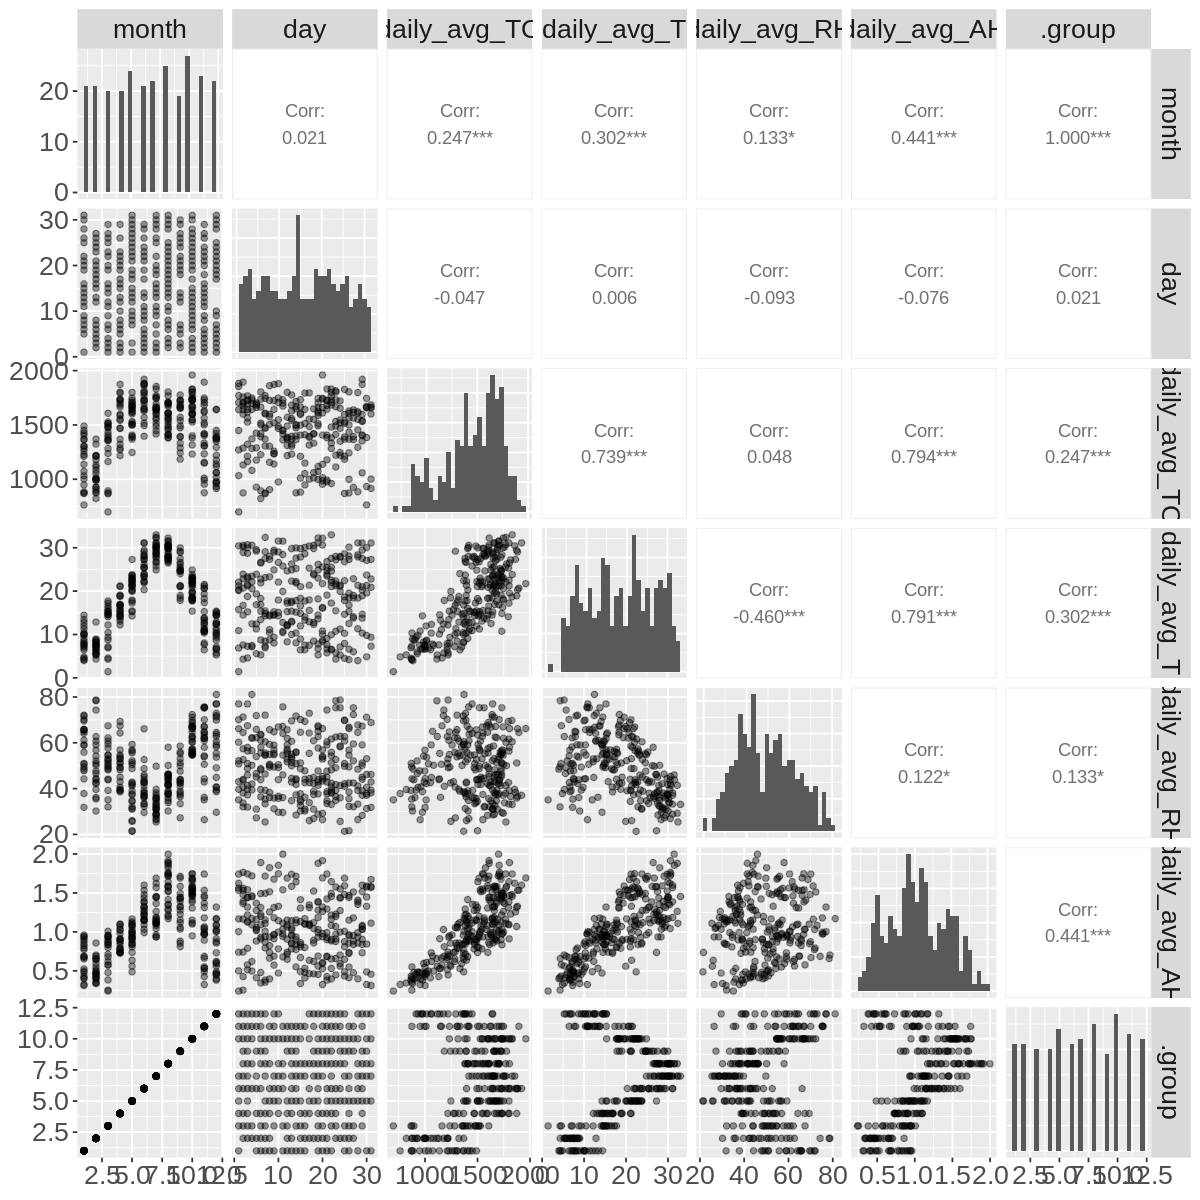

In [30]:
avg_air_quality_train_without_date <- avg_air_quality_train|>
    select(daily_avg_TO, daily_avg_T, daily_avg_RH, daily_avg_AH)

air_quality_pairplot <- avg_air_quality_train_without_date |> 
    ggpairs(
        lower = list(continuous = wrap('points', alpha = 0.4)),
        diag = list(continuous = "barDiag")
     ) +
     theme(text = element_text(size = 20))

redit_pairplot

In [29]:
lm_spec <- linear_reg() |>
    set_engine('lm') |>
    set_mode('regression')

air_quality_recipe <- recipe(daily_avg_TO ~ daily_avg_T, daily_avg_RH, daily_avg_AH, data = avg_air_quality_train)

air_quality_fit <- workflow() |>
    add_recipe(air_quality_recipe) |>
    add_model(lm_spec) |>
    fit(data = avg_air_quality_train)

In [28]:
air_quality_test_results <- air_quality_fit |>
  predict(avg_air_quality_test) |>
  bind_cols(avg_air_quality_test) |>
  mutate(residuals1 = .pred - daily_avg_TO)

air_quality_regression_metrics <- air_quality_test_results |>
    metrics(truth = daily_avg_TO, estimate = .pred)

head(air_quality_test_results)

air_quality_regression_metrics

.pred    month day daily_avg_TO daily_avg_T daily_avg_RH daily_avg_AH
1 1157.250 1      2  1063.1429     6.580952   59.28095     0.5709476   
2 1327.194 1     10  1482.9167    13.320833   68.66250     1.0445833   
3 1159.411 1     17  1163.3333     6.666667   46.91667     0.4469125   
4 1124.636 1     18  1306.3750     5.287500   66.27500     0.6079667   
5 1137.978 1     23   998.7500     5.816667   53.88333     0.5014125   
6 1184.836 1     24   977.4583     7.675000   47.88333     0.4938125   
  residuals1 
1   94.106760
2 -155.722767
3   -3.922454
4 -181.739437
5  139.228358
6  207.377399

.metric .estimator .estimate  
1 rmse    standard   167.9107233
2 rsq     standard     0.5809323
3 mae     standard   136.5575901